## Name: plot_vorticity.ipynb

Author: Robby M. Frost

University of Oklahoma

Created: 10 September 2024

Purpose: Functions for using lidar data

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gzip
import os
from functions import *
import matplotlib.pyplot as plt
from matplotlib import rc
import pyart
from matplotlib.ticker import MultipleLocator

Read in lidar file

In [21]:
# date/time info of lidar scans
des_year = "2024"
des_mon = "09"
des_day = "24"
des_file = "20240924234437_CAPPI_27.nc"
des_sys = "ARRC_Truck" # WG100-L0AD00003JP, WG100-L0AD00004JP, or ARRC_Truck
lidar_loc = "ARRC Mobile" # Hampton, VA or Oklahoma Mobile
# directory storing 24 hours of lidar data
directory = f"/data/arrcwx/robbyfrost/lidar_obs/{des_sys}/{des_year}/{des_mon}/{des_day}/"
# directory for saving figues
figdir = f"/home/robbyfrost/Analysis/TurbTor_Lidar/figures/{des_sys}/{des_year}/{des_mon}/{des_day}/"
os.makedirs(figdir, exist_ok=True)

des_elev = 5.

# start and end azimuths for averaging
az_start, az_end = 293.925, 358.99

dfile = directory + des_file
# with gzip.open(dfile, 'rb') as f:
ds = xr.open_dataset(dfile, engine='h5netcdf')
ds = ds.where(ds.elevation == des_elev, drop=True)

Set arrays

In [22]:
# account for range offset
range_offset = 1425 # meters
start_point = np.argmin(abs(ds.ranges[:,0].data-range_offset))+1
# scan dimensions
az = ds.azimuth.data# * -1 + 90
r = ds.ranges[start_point:,0].data - range_offset
el = ds.elevation.data
# radial velocity
vr = ds.dpl[:,0,start_point:].data * -1
# calculate vertical vorticity
vort_z = ( (vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis] ) * (1 / r)
# other observations
pwr = ds.pwr[:,0,start_point:].data * 100
snr = ds.snr[:,0,start_point:].data
sw = ds.wth[:,0,start_point:].data
noise_level = ds.noise_level[:,0,start_point:].data
# power_spectra = ds.power_spectra[:,0,start_point:].data
doppler_velocity = ds.doppler_velocity.data
# lidar information
ob_method = ds.attrs['observation_method']
serial_number = ds.attrs['serial_number']
lat = ds.latitude.data
lon = ds.longitude.data
altitude = ds.altitude.data
# scan setting information
rpm_azimuth = ds.rpm_azimuth[start_point:].data
# scan time information
record_start_time = ds.start_time.data
start_time = ds.attrs['start_time'][11:19]
start_date = ds.attrs['start_time'][:10]
end_time = ds.attrs['end_time'][11:19]
end_date = ds.attrs['end_time'][:10]

In [23]:
azs_idx, aze_idx = np.argmin(abs(az - az_start)), np.argmin(abs(az - az_end))
bh = beam_height_2D(r, el)
ridx = np.argmin(abs(bh[:,0]-250))
vort_z_avg = vort_z[azs_idx:aze_idx,10:ridx]

Plotting set up

In [24]:
# Set the font weight for plot titles
# plt.rcParams['axes.titleweight'] = 'bold'
# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='sans-serif')
rc('font', weight='normal', size=15)
rc('figure', facecolor='white')

In [25]:
XX, YY = dis_angle_to_2Dxy(r,north0_to_arctheta(az))

/tmp/ipykernel_1467668/206449013.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm1 = ax[0].pcolormesh(XX.T/1e3, YY.T/1e3, vr,


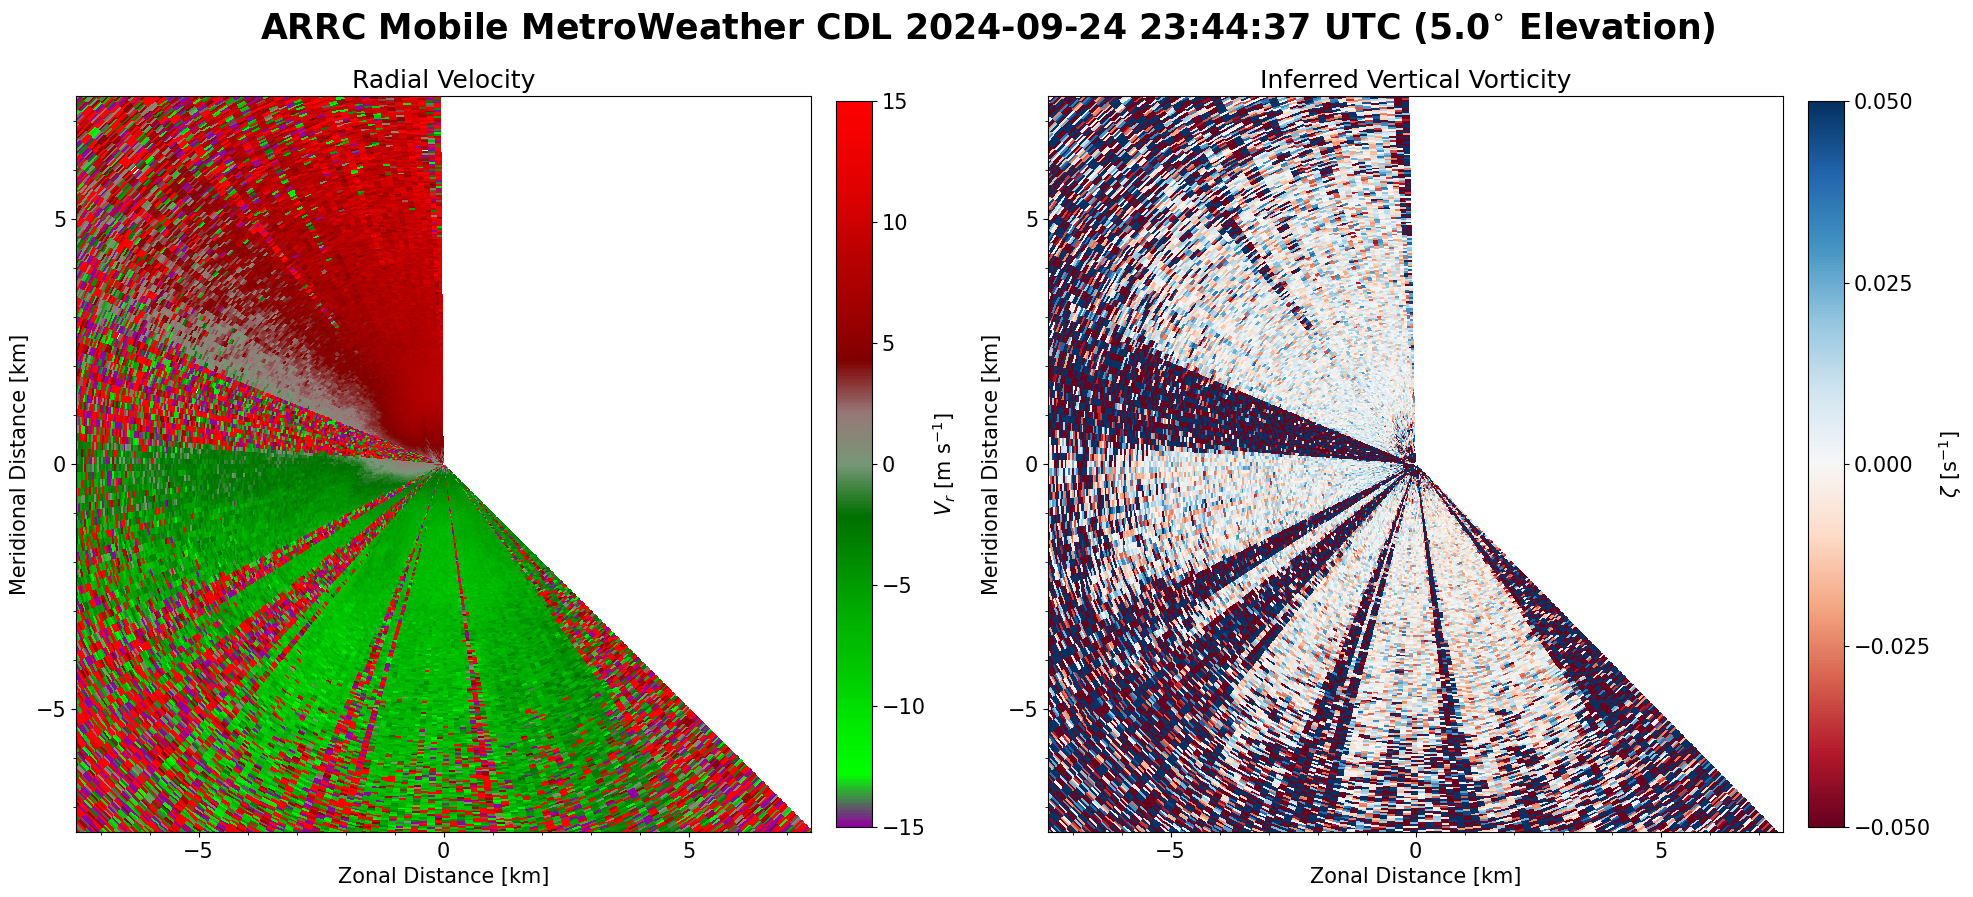

In [26]:
rmax = 7.5 # km

fig, ax = plt.subplots(figsize=(20,10), ncols=2)

vmin, vmax = -15, 15
pcm1 = ax[0].pcolormesh(XX.T/1e3, YY.T/1e3, vr,
                        vmin=vmin, vmax=vmax,
                        cmap="pyart_NWSVel")
ax[0].set_title("Radial Velocity")
cbar1 = fig.colorbar(pcm1, ax=ax[0], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar1.set_label("$V_r$ [m s$^{-1}$]")
cbar1.set_ticks(np.arange(vmin, vmax+0.001, 5))

vmin, vmax = -0.05, 0.05
pcm2 = ax[1].pcolormesh(XX.T/1e3, YY.T/1e3, vort_z[:,:-1],
                        vmin=vmin, vmax=vmax,
                        cmap="RdBu")
ax[1].set_title("Inferred Vertical Vorticity")
cbar2 = fig.colorbar(pcm2, ax=ax[1], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar2.set_label("$\\zeta$ [s$^{-1}$]")
cbar2.set_ticks(np.arange(vmin, vmax+0.0001, 0.025))

for iax in ax:
    iax.set_aspect('equal')
    iax.set_xlim(-rmax,rmax)
    iax.xaxis.set_major_locator(MultipleLocator(5))
    iax.xaxis.set_minor_locator(MultipleLocator(1))
    iax.set_xlabel("Zonal Distance [km]")
    iax.set_ylim(-rmax,rmax)
    iax.yaxis.set_major_locator(MultipleLocator(5))
    iax.yaxis.set_minor_locator(MultipleLocator(1))
    iax.set_ylabel("Meridional Distance [km]")

plt.suptitle(f"{lidar_loc} MetroWeather CDL {start_date} {start_time} UTC ({round(el[0],1)}$^{{\\circ}}$ Elevation)", 
             fontweight="bold", fontsize=25, y=0.925)

fig.tight_layout()

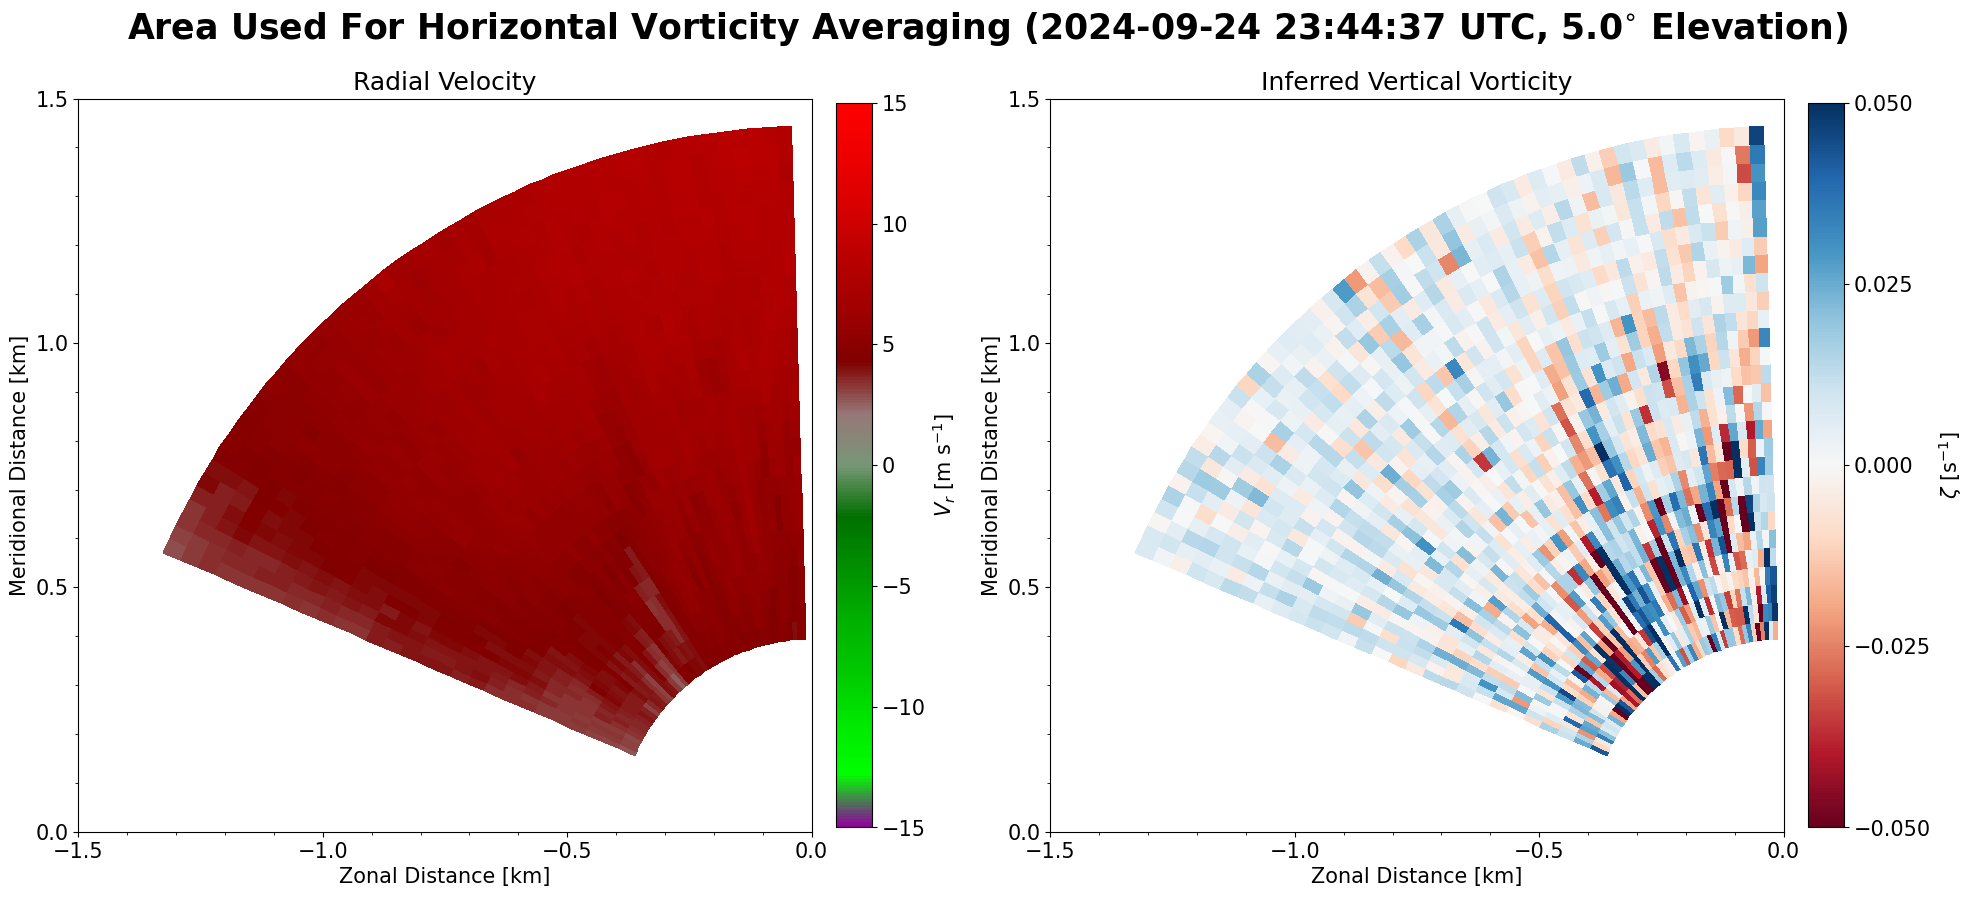

In [35]:
rmax = 1.5 # km

fig, ax = plt.subplots(figsize=(20,10), ncols=2)

vmin, vmax = -15, 15
pcm1 = ax[0].pcolormesh(XX.T[azs_idx:aze_idx,10:ridx]/1e3, 
                        YY.T[azs_idx:aze_idx,10:ridx]/1e3, 
                        vr[azs_idx:aze_idx,10:ridx],
                        vmin=vmin, vmax=vmax,
                        cmap="pyart_NWSVel")
ax[0].set_title("Radial Velocity")
cbar1 = fig.colorbar(pcm1, ax=ax[0], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar1.set_label("$V_r$ [m s$^{-1}$]")
cbar1.set_ticks(np.arange(vmin, vmax+0.001, 5))

vmin, vmax = -0.05, 0.05
pcm2 = ax[1].pcolormesh(XX.T[azs_idx:aze_idx,10:ridx]/1e3, 
                        YY.T[azs_idx:aze_idx,10:ridx]/1e3, 
                        vort_z_avg,
                        vmin=vmin, vmax=vmax,
                        cmap="RdBu")
ax[1].set_title("Inferred Vertical Vorticity")
cbar2 = fig.colorbar(pcm2, ax=ax[1], aspect=20, pad=0.03, fraction=0.06, shrink=0.81)
cbar2.set_label("$\\zeta$ [s$^{-1}$]")
cbar2.set_ticks(np.arange(vmin, vmax+0.0001, 0.025))

for iax in ax:
    iax.set_aspect('equal')
    iax.set_xlim(-rmax,0)
    iax.xaxis.set_major_locator(MultipleLocator(0.5))
    iax.xaxis.set_minor_locator(MultipleLocator(0.1))
    iax.set_xlabel("Zonal Distance [km]")
    iax.set_ylim(0,rmax)
    iax.yaxis.set_major_locator(MultipleLocator(0.5))
    iax.yaxis.set_minor_locator(MultipleLocator(0.1))
    iax.set_ylabel("Meridional Distance [km]")

plt.suptitle(f"Area Used For Horizontal Vorticity Averaging ({start_date} {start_time} UTC, {round(el[0],1)}$^{{\\circ}}$ Elevation)", 
             fontweight="bold", fontsize=25, y=0.925)

fig.tight_layout()